# Collect features
The federal office of public health is publishing all covid19 data under covid19.admin.ch. All data is persisted in csv files and documented.

Documentation of the data https://www.covid19.admin.ch/api/data/documentation

Download https://www.covid19.admin.ch/de/hosp-capacity/icu, zuunterst bei 'Daten herunterladen'

We decided to use the following features for our work.

| Feature Name|Description|Raw CSV|Feature name in raw data|Special |
|-------------------|--------------------|:-----------------------------:|:-----------------------:|:-------------:|
|cases|Absolute number of occurrences for this day.|COVID19Cases_geoRegion.csv|        entries | ddd|
|vaccination_atLeastOneDosePersons|Number of persons that have received at least one dose|COVID19VaccPersons_v2.csv|type |age_group=total_population - records containing data for the total population|
|vaccination_firstBoosterPersons|Number of persons that have received at least one booster vaccine dose. Subset of the 'COVID19FullyVaccPersons'|COVID19VaccPersons_v2.csv|type |age_group=total_population - records containing data for the total population|
|vaccination_fullyVaccPersons|Number of fully vaccinated persons|COVID19VaccPersons_v2.csv| type |age_group=total_population - records containing data for the total population|
|vaccination_partiallyVaccPersons|Number of persons that are partially vaccinated (difference between COVID19AtLeastOneDosePersons and COVID19FullyVaccPersons)|COVID19VaccPersons_v2.csv| type |age_group=total_population - records containing data for the total population|
|certificate_all|Sum of all COVID certificates issued.|COVID19Certificates.csv|        type_variant ||
|certificate_recovered| Issued COVID certificates for persons that have recovered from COVID-19.|COVID19Certificates.csv|        type_variant ||
|certificate_tested|Issued COVID certificates for persons with a negative test result.|COVID19Certificates.csv|        type_variant ||
|certificate_vacinated| Issued COVID certificates for vaccinated persons.|COVID19Certificates.csv|        type_variant ||
|hosp_total_icu_covid|Absolute number of ICU beds in use by COVID-19 patients.|COVID19HospCapacity_geoRegion|        ICU_Covid19Patients |type_variant=nfp Reported date is only valid for the current day, no forward propagation is done. Each record reflects the data reported for that specific day.|
|hosp_total_covid |Absolute number of beds in use by COVID-19 patients.|COVID19HospCapacity_geoRegion|        Total_Covid19Patients |type_variant=nfp Reported date is only valid for the current day, no forward propagation is done. Each record reflects the data reported for that specific day.|
|death|Absolute number of occurrences for this iso-week.|COVID19Death_geoRegion.|        entries ||




In [1]:
# Usual Imports
import pandas as pd
import sys

# Configuration
Change the variable data_path to your local git repo path

In [2]:
#Path to raw_data -> change it localy
data_path =  "C:/Users/marco/IdeaProjects/ml-corona/data/"


raw_data_path = f"{data_path}raw_data/"
stripped_data_path = f"{data_path}stripped_data/"


Mit diesen beiden Variablen wird bei jedem hinzufügen zu all_data die Anzahl Zeilen und Spalten kontrolliert. 

In [3]:
#Quality Check
number_of_rows = 0
number_of_columns = 0

In [4]:
# Filter for data in georegion 'CH'. Extract the column 'entries' and 'date' (index) from given csv file 'csv_filename' and rename the column entries to given
# nae 'new_column_name'. Return the dataframe with two column
def extract_CH_entries(csv_filename, new_column_name):
    data = pd.read_csv(f"{raw_data_path}{csv_filename}", index_col = 1, encoding = "UTF-8")
    #Remove all not having geoRegion = 'CH'
    data = data[data['geoRegion'] == 'CH']
    #New dataframe with only datum and data
    data = data[['entries']]
    data =  data.rename({'entries': new_column_name}, axis=1, inplace=False)
    return data

# Append the given new_data_matrix to the all_data frame. Check the row and columns
def append_to_all_data(new_data_matrix, type):
    global all_data
    new_columns = new_data_matrix.shape[1]
    old_columns = all_data.shape[1]
    new_rows = new_data_matrix.shape[0]
    if new_rows > number_of_rows:
        sys.exit(f"Number of rows increased from {number_of_rows} to {new_rows}!")
    all_data = all_data.join(new_data_matrix, how='left',rsuffix='_other')
    actual_columns = all_data.shape[1]
    if ( actual_columns > (old_columns + new_columns)):
        sys.exit(f"Number of columns is wrong. There were {old_columns} added {new_columns}, but now are {actual_columns}")
    print(f"Shape after {type} {all_data.shape}, added {new_columns} columns")

# Cases
First data to add. Initialyse the validation with number_of_rows and number_of_columns.


In [5]:
cases = extract_CH_entries('COVID19Cases_geoRegion.csv','cases')
all_data = cases
number_of_rows = all_data.shape[0]
number_of_columns = all_data.shape[1]
print(f"Shape after cases {all_data.shape}")

Shape after cases (662, 1)


# Vaccinations
Filter for geoRegion 'CH' and age_group 'totoal_population'. Extract the column values to columns with a pivot table. So we have four new data columns.

Shape after vaccination (662, 5), added 4 columns


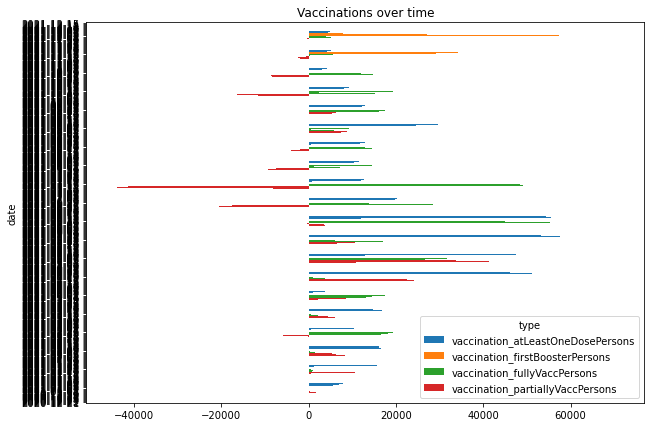

In [6]:
vaccination = pd.read_csv(f"{raw_data_path}COVID19VaccPersons_v2.csv", index_col = 0, encoding = "UTF-8")

#Remove all not having geoRegion = 'CH'
vaccination = vaccination[vaccination['geoRegion'] == 'CH']
#Only look in age_group == 'total_population'
vaccination = vaccination[vaccination['age_group'] == 'total_population']

pivot = vaccination.pivot_table(values="entries", index=vaccination.index, columns="type", aggfunc='first')
pivot = pivot.rename({'COVID19AtLeastOneDosePersons': 'vaccination_atLeastOneDosePersons', 'COVID19FirstBoosterPersons' : 'vaccination_firstBoosterPersons','COVID19FullyVaccPersons': 'vaccination_fullyVaccPersons', 'COVID19PartiallyVaccPersons' : 'vaccination_partiallyVaccPersons'}, axis=1, inplace=False)

pivot.plot.barh(figsize=(10,7),title='Vaccinations over time')

append_to_all_data(pivot, 'vaccination')

# Certificate
Create columns with values in Column 'type_variant' with a pivot table. So we have 4 new columns.

In [7]:
#Read certificate
certificate = pd.read_csv(f"{raw_data_path}COVID19Certificates.csv", index_col = 0, encoding = "UTF-8")
#Reorgainisation of columns. Values of rows in column type_variant are 'all', 'recovered', 'tested','vaccinated'. Generate columns for every value.
certificate = certificate.pivot_table('entries', ['date'], 'type_variant')
certificate = certificate.rename({'all': 'certificate_all', 'recovered' : 'certificate_recovered', 'tested' : 'certificate_tested', 'vaccinated' : 'certificate_vacinated'}, axis=1, inplace=False)

append_to_all_data(certificate, 'certificate')

Shape after certificate (662, 9), added 4 columns


# Hospitalisation 
Filter geoRegion 'CH' and type_variant 'nfp' (Reported date is only valid for the current day). Only select two columms for total covid19 patients and ICU (intensive care unit) patients.

In [8]:
hospital_capacity = pd.read_csv(f"{raw_data_path}COVID19HospCapacity_geoRegion.csv", index_col = 0, encoding = "UTF-8")

#Remove all not having geoRegion = 'CH'
hospital_capacity = hospital_capacity[hospital_capacity['geoRegion'] == 'CH']
# type_variant should only be nfp (Reported date is only valid for the current day)
hospital_capacity = hospital_capacity[hospital_capacity['type_variant'] == 'nfp']

selected_columns = hospital_capacity[["ICU_Covid19Patients","Total_Covid19Patients"]]
selected_columns = selected_columns.rename({'ICU_Covid19Patients': 'hosp_total_icu_covid', 'Total_Covid19Patients' : 'hosp_total_covid'}, axis=1, inplace=False)
hospital_capacity = selected_columns.copy()

append_to_all_data(hospital_capacity, 'hospital_capacity')

Shape after hospital_capacity (662, 11), added 2 columns


# Death
Add the death entries as column 'death' to all_data.

In [9]:
death = extract_CH_entries('COVID19Death_geoRegion.csv','death')

append_to_all_data(death, 'death')

Shape after death (662, 12), added 1 columns


# Persist result
Persist the result in a all_data.csv file.

In [10]:
#save dataframe
all_data.to_csv(f"{stripped_data_path}all_data.csv",index=True)